## Different imports and setup

In [1]:
# Standard import
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
# Machine learning libraries
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm

In [3]:
# Custom plots file and tensorflow models
from Tools import Plot
from Tools import Custom_models
from Tools import Helpers

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('Not working on GPU !')
else:
  print('Found GPU at: {}'.format(device_name))

Not working on GPU !


In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Set the seeds and extract the training data

In [6]:
# Set the seed for reproducibility
seed = 6
np.random.seed(seed)
tf.random.set_seed(seed*2)

In [7]:
# Load the data
features_train, labels_train, features_val, labels_val, features_test, labels_test = Helpers.Load_and_split_val(
    'Data/tanh_10D.txt', D=10, seed=seed, ratio_test=0.1, ratio_val=0.1)

In [8]:
print(f'We will be training on {len(features_train)} examples !')
print(f'We will be validating on {len(features_val)} examples !')
print(f'And testing on {len(features_test)} examples !')

We will be training on 80000 examples !
We will be validating on 10000 examples !
And testing on 10000 examples !


## Define the parameters and train all the models

In [9]:
batches = [32, 64, 128]
Ks = [40*i for i in range(1,6)]
N_model = 5

In [10]:
learning_rate = 5e-5
K_out = 1
N_epochs = 250

In [ ]:
for i, batch in tqdm(enumerate(batches)):
    
    for j, K in tqdm(enumerate(Ks)):
        
        for k in tqdm(range(N_model)):
            
            name = f'batch_{batch}-K_{K}-lr_{learning_rate:.1e}'
            save_name = f'Saved_models/10D/2_layer_width_study/batch_{batch}-K_{K}-iter_{k}'
            opt = Adam(learning_rate=learning_rate)
            
            model = Custom_models.Model_depth(K1=K, K_output=K_out, depth=2, name=name)
            model.compile(loss=MeanSquaredError(), optimizer=opt)
            
            logger = tf.keras.callbacks.CSVLogger(save_name + '.csv')
            saver = tf.keras.callbacks.ModelCheckpoint(save_name, save_best_only=True, mode='min')
            
            history = model.fit(features_train, labels_train, validation_data=(features_val, labels_val),
                                epochs=N_epochs, batch_size=batch, validation_batch_size=batch, verbose=0,
                                shuffle=True, initial_epoch=0, callbacks=[logger, saver])
    

# Study the results

In [13]:
batches = [32, 64, 128]
Ks = [40*i for i in range(1,6)]
N_model = 5

MSE = np.zeros((len(batches), len(Ks), N_model))
MAE = np.zeros((len(batches), len(Ks), N_model))
MaAE = np.zeros((len(batches), len(Ks), N_model))

for i, batch in enumerate(batches):
    
    for j, K in enumerate(Ks):
        
        for k in range(N_model):
            
            name = f'Saved_models/10D/2_layer_width_study/batch_{batch}-K_{K}-iter_{k}'
            model = keras.models.load_model(name)
            MSE[i,j,k] = Helpers.MSE(model, features_test, labels_test)
            MAE[i,j,k] = Helpers.MAE(model, features_test, labels_test)
            MaAE[i,j,k] = Helpers.MaAE(model, features_test, labels_test)
            

mean_MSE = np.mean(MSE, axis=-1)  
mean_MAE = np.mean(MAE, axis=-1)  
mean_MaAE = np.mean(MaAE, axis=-1) 

max_MSE = np.max(MSE, axis=-1)
max_MAE = np.max(MAE, axis=-1)
max_MaAE = np.max(MaAE, axis=-1)

min_MSE = np.min(MSE, axis=-1)
min_MAE = np.min(MAE, axis=-1)
min_MaAE = np.min(MaAE, axis=-1)

lower_error_MSE = mean_MSE - min_MSE
upper_error_MSE = max_MSE - mean_MSE
lower_error_MAE = mean_MAE - min_MAE
upper_error_MAE = max_MAE - mean_MAE
lower_error_MaAE = mean_MaAE - min_MaAE
upper_error_MaAE = max_MaAE - mean_MaAE

error_MSE = np.stack([lower_error_MSE, upper_error_MSE], axis=1)
error_MAE = np.stack([lower_error_MAE, upper_error_MAE], axis=1)
error_MaAE = np.stack([lower_error_MaAE, upper_error_MaAE], axis=1)

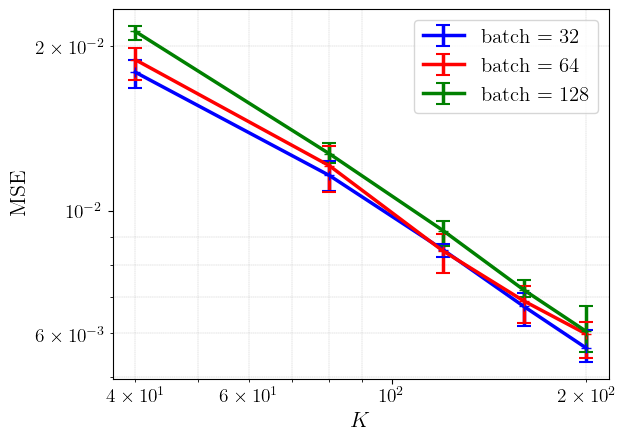

In [17]:
plt.figure()
plt.errorbar(Ks, mean_MSE[0,:], error_MSE[0,:], label='batch = 32', color='b', linestyle='-',
             marker='+', capsize=5, capthick=1.5)
plt.errorbar(Ks, mean_MSE[1,:], error_MSE[1,:], label='batch = 64', color='r', linestyle='-',
             marker='+', capsize=5, capthick=1.5)
plt.errorbar(Ks, mean_MSE[2,:], error_MSE[2,:], label='batch = 128', color='g', linestyle='-',
             marker='+', capsize=5, capthick=1.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$K$')
plt.ylabel('MSE')
plt.legend()
plt.grid(True,'minor',linestyle='--',linewidth=0.25)
#plt.savefig('Figures/10D/2_layers/width_study_MSE.pdf', bbox_inches='tight')
plt.show()

In [24]:
from scipy import stats
test = stats.linregress(np.log10(Ks), np.log10(mean_MSE[2,:]))

In [25]:
print(f'The slope is : {test.slope:.2f} +- {test.stderr:.2f}')
print(f'The intercept is : {test.intercept:.2f} +- {test.intercept_stderr:.2f}')

The slope is : -0.78 +- 0.01
The intercept is : -0.41 +- 0.03


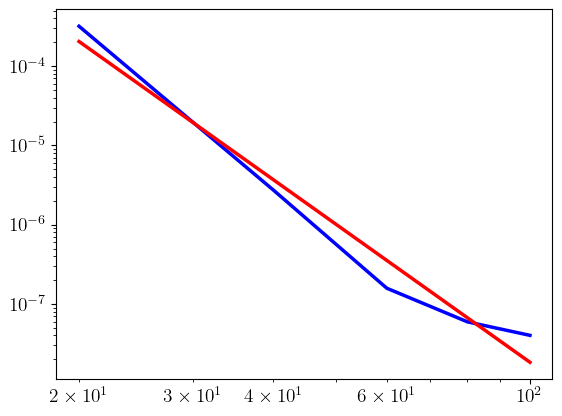

In [36]:
plt.figure()
plt.plot(Ks, mean_MSE[2,:], 'b-')
plt.plot(Ks, np.array(Ks)**test.slope*10**test.intercept, 'r-')
plt.yscale('log')
plt.xscale('log')

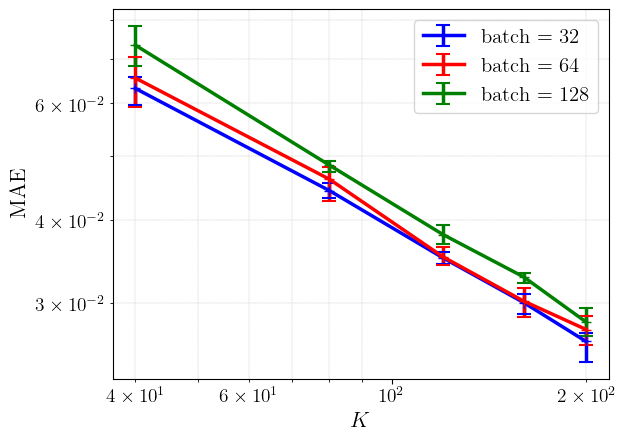

In [18]:
plt.figure()
plt.errorbar(Ks, mean_MAE[0,:], error_MAE[0,:], label='batch = 32', color='b', linestyle='-',
             marker='+', capsize=5, capthick=1.5)
plt.errorbar(Ks, mean_MAE[1,:], error_MAE[1,:], label='batch = 64', color='r', linestyle='-',
             marker='+', capsize=5, capthick=1.5)
plt.errorbar(Ks, mean_MAE[2,:], error_MAE[2,:], label='batch = 128', color='g', linestyle='-',
             marker='+', capsize=5, capthick=1.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$K$')
plt.ylabel('MAE')
plt.legend()
plt.grid(True,'minor',linestyle='--',linewidth=0.25)
#plt.savefig('Figures/10D/2_layers/width_study_MAE.pdf', bbox_inches='tight')
plt.show()

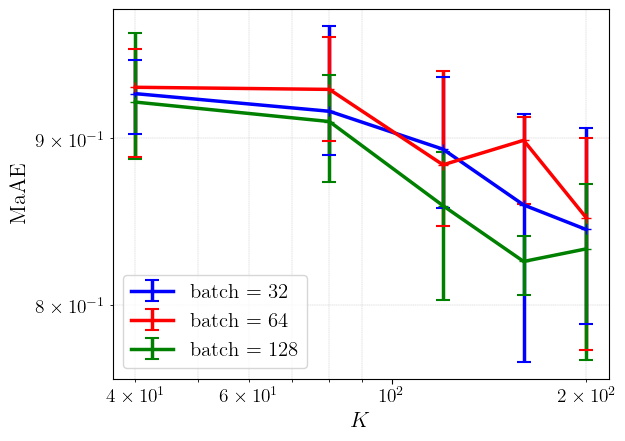

In [19]:
plt.figure()
plt.errorbar(Ks, mean_MaAE[0,:], error_MaAE[0,:], label='batch = 32', color='b', linestyle='-',
             marker='+', capsize=5, capthick=1.5)
plt.errorbar(Ks, mean_MaAE[1,:], error_MaAE[1,:], label='batch = 64', color='r', linestyle='-',
             marker='+', capsize=5, capthick=1.5)
plt.errorbar(Ks, mean_MaAE[2,:], error_MaAE[2,:], label='batch = 128', color='g', linestyle='-',
             marker='+', capsize=5, capthick=1.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$K$')
plt.ylabel('MaAE')
plt.legend()
plt.grid(True,'minor',linestyle='--',linewidth=0.25)
#plt.savefig('Figures/10D/2_layers/width_study_MaAE.pdf', bbox_inches='tight')
plt.show()